# SegNet Implementation (Colon Polyp Segmentation) | Christian H. Nunez

In [1]:
# Imports
from __future__ import division
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Reshape
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Layer
from PIL import Image
import codecs, json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 14

## Seeding 
seed = 2019
random.seed = seed
tf.seed = seed

print(keras.__version__)

/Users/ChristianHaroldNunez/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


2.2.4


In [2]:
# Set constants
image_size = 128
train_path = "/Users/ChristianHaroldNunez/Desktop/colons/CVC-ClinicDB/"
epochs = 10
batch_size = 8

In [3]:
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def saveHist(path,history):
    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
           if  type(history.history[key][0]) == np.float64:
               new_hist[key] = list(map(float, history.history[key]))

    print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 

SegNet base: https://github.com/ykamikawa/tf-keras-SegNet

In [4]:
class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = K.tf.nn.max_pool_with_argmax(
                    inputs,
                    ksize=ksize,
                    strides=strides,
                    padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
                dim//ratio[idx]
                if dim is not None else None
                for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with K.tf.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = K.tf.shape(updates, out_type='int32')
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                        input_shape[0],
                        input_shape[1]*self.size[0],
                        input_shape[2]*self.size[1],
                        input_shape[3])
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype='int32')
            batch_shape = K.concatenate(
                    [[input_shape[0]], [1], [1], [1]],
                    axis=0)
            batch_range = K.reshape(
                    K.tf.range(output_shape[0], dtype='int32'),
                    shape=batch_shape)
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = K.tf.range(output_shape[3], dtype='int32')
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = K.tf.size(updates)
            indices = K.transpose(K.reshape(
                K.stack([b, y, x, f]),
                [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = K.tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )

In [5]:
def segnet(
        input_shape,
        n_labels,
        kernel=3,
        pool_size=(2, 2),
        output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_13)
    print("Build encoder done..")

    # decoder

    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    
    outputs = Convolution2D(3, (1, 1), padding="same", activation="sigmoid")(conv_25)
    
    #conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    #conv_26 = BatchNormalization()(conv_26)
    #conv_26 = Reshape(
            #(input_shape[0]*input_shape[1], n_labels),
            #input_shape=(input_shape[0], input_shape[1], n_labels))(conv_26)

    #outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

In [6]:
# Set the model, optimizer. Compile and load weights, and summarize.
model = segnet((128, 128,1), n_labels=2, kernel=2, pool_size=(2,2), output_mode="softmax")
adam = keras.optimizers.Adam(lr=.0001)
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef, "binary_accuracy", "mse"])
model.load_weights("firsttry_2_50_50.h5")
model.summary()

Build encoder done..
Build decoder done..
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 64) 0           batch_normalization_1[0][0]      
___________________________________________________________________

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import itertools as itt


def combineGenerator(gen1, gen2):
    while True:
        #print(gen1.next()[0].shape, gen2.next()[0].shape)
        yield(gen1.next()[0], gen2.next()[0])

epochs = 10
batch_size = 1
data_aug_path = '/Users/ChristianHaroldNunez/Desktop/colons/CVC-ClinicDB/data_aug2/'


data_gen_args=dict(rescale=1./255,
        rotation_range=360,    
        brightness_range=(0.4, 0.6),
        vertical_flip=True,
        horizontal_flip=True)


# Making image data for TRAINING images
train_image_datagen = ImageDataGenerator(**data_gen_args)
train_mask_datagen = ImageDataGenerator(**data_gen_args)

seed1 = 230

train_image_generator = train_image_datagen.flow_from_directory(data_aug_path+'train/Org_upper',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    seed=seed1,
    color_mode='grayscale')

train_mask_generator = train_mask_datagen.flow_from_directory(data_aug_path+'train/GT_upper',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    seed=seed1)

train_generator = combineGenerator(train_image_generator, train_mask_generator)


# Making image data for VALIDATION images
validation_image_datagen = ImageDataGenerator(rescale=1./255)
validation_mask_datagen = ImageDataGenerator(rescale=1./255)

validation_image_generator = validation_image_datagen.flow_from_directory(data_aug_path+'val/Org_upper',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    seed=seed1,
    color_mode='grayscale')

validation_mask_generator = validation_mask_datagen.flow_from_directory(data_aug_path+'val/GT_upper',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    seed=seed1)

validation_generator = combineGenerator(validation_image_generator, validation_mask_generator)


# Compute training and validation steps
train_steps = 425//batch_size
valid_steps = 50//batch_size

print(type(validation_generator))

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=valid_steps
)


model.save_weights('firsttry_2_50_50_10.h5')

In [ ]:
# Save the history (if desired)
saveHist('/Users/ChristianHaroldNunez/Desktop/image-segmentation-keras/weights/segnet_dataaug_adam0001_2_50_50_10.json', 
         history)        

In [ ]:
# For example, plot the history of the validation dice_coefficients:
plt.plot(history.history['val_dice_coef'], marker='o')

## Viewing Predictions

In [8]:
# Custom data generator -- easy to manage than ImageDataGenerator
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
     
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "Org", id_name) + ".png"
        mask_path = os.path.join(self.path, "GT", id_name) + ".png"
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = np.expand_dims(image, axis=-1)
        
        ## Reading Masks
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask = np.expand_dims(mask, axis=-1)
        #mask = np.maximum(np.zeros((self.image_size, self.image_size, 1)), mask)
                    
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [9]:
# Image data generators for viewing of test and train images. Filenames also collected.
seed1 = 230
test_image_datagen = ImageDataGenerator(rescale=1./255)
test_mask_datagen = ImageDataGenerator(rescale=1./255)

test_image_generator = test_image_datagen.flow_from_directory(data_aug_path+'test/Org_upper',
    target_size=(image_size, image_size),
    batch_size=1,
    seed=seed1,
    color_mode='grayscale')

filenames = test_image_generator.filenames

test_mask_generator = test_mask_datagen.flow_from_directory(data_aug_path+'test/GT_upper',
    target_size=(image_size, image_size),
    batch_size=1,
    seed=seed1)

test_generator = combineGenerator(test_image_generator, test_mask_generator)


# See result on train images
train_image_generator = train_image_datagen.flow_from_directory(data_aug_path+'train/Org_upper',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    seed=seed1,
    color_mode='grayscale')

filenames_train = train_image_generator.filenames

train_mask_generator = train_mask_datagen.flow_from_directory(data_aug_path+'train/GT_upper',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    seed=seed1)

train_generator = combineGenerator(train_image_generator, train_mask_generator)

evals = model.evaluate_generator(test_generator, steps=127)

Found 127 images belonging to 1 classes.
Found 127 images belonging to 1 classes.
Found 425 images belonging to 1 classes.
Found 425 images belonging to 1 classes.


In [10]:
# Evaluations of SegNet on the test data:
print(model.metrics_names)
print(evals)

['loss', 'dice_coef', 'binary_accuracy', 'mean_squared_error']
[-0.23329609211311514, 0.23329609211311514, 0.7862899646045655, 0.21000752598047256]


In [11]:
# Filenames of test images from test_generator above
test_ids = []
trainer_ids = []
for i in range(0, len(filenames)):
    test_ids.append(str(filenames[i].split(".")[0].split("/")[1]))

for i in range(0, len(filenames_train)):
    trainer_ids.append(str(filenames_train[i].split(".")[0].split("/")[1]))

train_path = "/Users/ChristianHaroldNunez/Desktop/colons/CVC-ClinicDB/"
test_gen = DataGen(test_ids, train_path, image_size=image_size, batch_size=127)
trainer_gen = DataGen(trainer_ids, train_path, image_size=image_size, batch_size=425)

xx, yy = test_gen.__getitem__(0)
xt, yt = trainer_gen.__getitem__(0)
print(xt.shape, yt.shape)

((425, 128, 128, 1), (425, 128, 128, 1))


In [12]:
n = 25
x = np.expand_dims(xt[n], axis=0)
y = np.expand_dims(yt[n], axis=0)
x.shape

(1, 128, 128, 1)

In [13]:
results = []
result = model.predict(x)

result = result > 0.5
result.shape
# for i in range(0, 127):
#     result = model.predict(np.expand_dims(x[i], axis=0))
#     result = result > 0.5
#     results.append(result)

(1, 128, 128, 3)

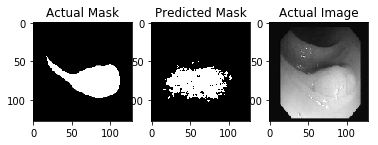

In [14]:
fig, ax = plt.subplots(1, 3)

# Predicted Mask
ax[0].set_title("Actual Mask")
ax[0].imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

# Actual Mask'
ax[1].set_title("Predicted Mask")
ax[1].imshow(np.reshape(result[0][:,:,0]*255, (image_size, image_size)), cmap="gray")

# Actual Image
ax[2].set_title("Actual Image")
ax[2].imshow(np.reshape(x[0][:,:,0]*255, (image_size, image_size)), cmap="gray")

The SegNet predictions seem to localize the colon polyp somewhat well, but the masks are much grainier. Compare to the solid masks of the U-Net.